# Multiclass Classification Problem

# Check GPU
We strongly recommend the use of GPU for training. If you are on Google Colab, go to change runtime type to GPU on the top menu.

In [1]:
!nvidia-smi

Sun Mar  2 19:05:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             15W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install aisee matplotlib requests split-folders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 847.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import zipfile

import matplotlib.pyplot as plt
import requests
import splitfolders
from aisee import DatasetFromFolder, Trainer, VisionClassifier
from PIL import Image

## Get the data

In this section of code, we are **downloading and extracting a dataset of microorganism images** from a .zip file hosted on **Hugging Face**.

First, the current working directory of the notebook is obtained and stored in the variable `notebook_dir`.

Next, the URL of the .zip file is defined and stored in the `url` variable.

The dataset is then downloaded using the `requests` library, and the content of the response is written to a file named `data.zip` in the current working directory.

Finally, the `zipfile` library is utilized to extract the contents of the downloaded .zip file into the current working directory, after which the .zip file is closed.

In [4]:
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Define the URL to download the dataset
url = 'https://huggingface.co/IIC/aisee_resources/resolve/main/microorganisms.zip'

response = requests.get(url)

# Download the dataset from the URL and save it as "data.zip" in the current working directory
with open('data.zip', 'wb') as file:
    file.write(response.content)

# Extract the contents of the downloaded zip file into the current working directory
archivo_zip = zipfile.ZipFile(os.path.join(notebook_dir, 'data.zip'))
archivo_zip.extractall(os.path.join(notebook_dir))
archivo_zip.close()

Now we have this folder structure:

    └── data
        └── test
        │   └── Amoeba
        │   └── Euglena
        │   └── Hydra
        │   └── Paramecium
        │   └── Rod_bacteria
        │   └── Spherical_bacteria
        │   └── Spiral_bacteria
        │   └── Yeast
        └── train
        │   └── Amoeba
        │   └── Euglena
        │   └── Hydra
        │   └── Paramecium
        │   └── Rod_bacteria
        │   └── Spherical_bacteria
        │   └── Spiral_bacteria
        │   └── Yeast
        └── val
            └── Amoeba
            └── Euglena
            └── Hydra
            └── Paramecium
            └── Rod_bacteria
            └── Spherical_bacteria
            └── Spiral_bacteria
            └── Yeast



In [5]:
splitfolders.ratio('micro_organism', output="data", seed=42, ratio=(0.7, 0.1, 0.2))

Copying files: 789 files [00:00, 3699.79 files/s]


The task that will be performed with this data is to train a model to classify images of microorganisms.
Let's see some images:

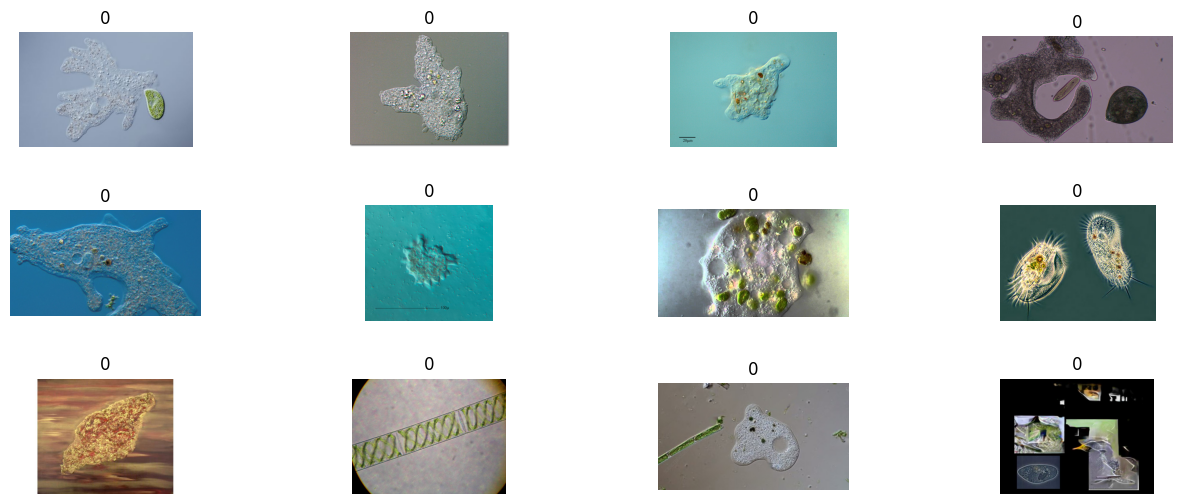

In [6]:
#Create the dataset
train_df = DatasetFromFolder('data/train')

#Plot images
f,ax = plt.subplots(3,4, figsize=(15, 6))
f.subplots_adjust(wspace=0.7, hspace=0.5)
for i, (img, label, path) in enumerate(train_df):
    if i >= 12:
        break
    ax[i//4,i%4].imshow(Image.open(path))
    ax[i//4,i%4].axis('off')
    ax[i//4,i%4].set_title(label)
plt.show()


## VisionClassifier Instance

These are all parameters with their respective explanations:

- **model_name**: (`str`) Name of the model that will be obtained from the timm library.

- **num_classes**: (`int`) Number of classes in the problem. The number of classes will be the number of outputs of the neural net.

- **class_to_idx**: (dict[`str`, `int`], default=None) Equivalence between the label and the index of the neural net output. This parameter is equivalent to label2id of the transformers library.

- **weights_path**: (`str`, default=None) Directory where network weights are located. If value is different from None, pretrained weigths from the timm library will be ignored.

- **learning_method**: (`str`, default="freezed") Possible values: from_scratch, freezed, and unfreezed:
    - **from_scratch**: The model will be trained from scratch, without using any pre-trained weights contained in the timm library.
    - **freezed**: The model will be trained using pre-trained weights from the timm library. For this training, all layers of the network will be frozen (weights will not be updated) except for the last - layer, and the extra layer if it is added with the extra_layer parameter.
    - **unfreezed**: The model will be trained using pre-trained weights from the timm library. In this case, all layers of the network will be updated without exception.

    Note that if custom weights are passed in the custom_weights parameter, the network weights will be those, and the pre-trained weights from the timm library will be ignored.

- **extra_layer**: (`int`, default=None) If value is different from None, a linear layer is added before the last layer with extra_layer number of neurons. If None, this does nothing.

- **dropout**: (`float`, default=None) If dropout has a value different from None, dropout layer is added before the last layer. Otherwise, this does nothing.

- **task**: (`str`, default="single_label") Task to be resolved. Possible values: "single_label", "multi_label".

- **device**: (`str`, default="cpu") Device where the neural network will be running. Example: "cuda:1", "cpu".

In [7]:
model_name = 'densenet121'
num_classes = 8
class_to_idx = {
    "Amoeba": 0,
    "Euglena": 1,
    "Hydra": 2,
    "Paramecium": 3,
    "Rod_bacteria": 4,
    "Spherical_bacteria": 5,
    "Spiral_bacteria": 6,
    "Yeast": 7
}


classifier = VisionClassifier(model_name, num_classes, class_to_idx, task='single_label', device='cuda:0')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

## Trainer Instance

These are all parameters with their respective explanations:

* **base_model** (`VisionClassifier`): An instance of VisionClassifier.

* **data** (`Union[pd.DataFrame, str]`): A DataFrame or a string which contains the training data:
    * If it is a dataframe:
        * If it is a multiclass problem: the dataframe must contain a `path` column with the full path of the image, a `label` column with the label assigned to the image and a `fold` column that indicates the 'train' and 'val' samples.
        * If it is a multilabel problem: the dataframe must contain a "path" column with the full path of the image, one column for each class in the problem and a `fold` column . The classes that belong to that image will be indicated with a "1" and those that do not with a "0".
    * If it is a string, it must be a directory which should contain subfolders with training ('train') and validation ('val') samples and second subfolders with labels.

* **output_dir** (`str`, default=None): File where the weights of the neural network will be saved. If None output_dir = 'weights_model_name_time.pt'

* **lr** (`float`, default=0.001): Learning rate used by the torch optimizer.

* **batch_size** (`int`, default=16): Number of training samples.

* **num_epochs** (`int`, default=5): Number of training epochs.

* **checkpointing_metric** (`str`, default="loss"): Metric with which the best model will be saved. Possible values: 'loss', 'acc', 'f1'. F1 is calculated as 'macro-averaged F1 score'.

* **verbose** (`int`, default=3): Controls the verbosity: the higher, the more messages.

* **shuffle** (`bool`, default=True): Whether or not to shuffle the data before splitting.

* **num_workers** (`int`, default=2): How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.

* **dict_data_transforms** (`dict`, default=None): Dict with 'train' and 'val' image transformations. A function/transform that takes in an PIL image and returns a transformed version. If None for train: resize, horizontal flip and normalize, val: resize and normalize.

* **criterion** (`Type[Loss]`, default=CrossEntropyLoss for single_label, default=BCELoss for multi_label): A loss function from pytorch. This criterion computes loss between input logits and target.

* **optimizer** (`Type[Optimizer]`, default=None): Add an optimizer from pytorch. If None Adam will be used.

* **optimer_kwargs** (`dict`, default=None): Optimizer parameters.

In [8]:
trainer = Trainer(output_dir="test_trainer.pt", base_model=classifier, data="data", batch_size=4, num_epochs=10)

## Train

In [9]:
trainer.train()

Initializing Dataloaders...


INFO:aisee.trainer:Initializing Dataloaders...


INFO:aisee.trainer:



Params to learn:


INFO:aisee.trainer:Params to learn:


classifier.weight
classifier.bias



INFO:aisee.trainer:classifier.weight
classifier.bias



Epoch 1/10


INFO:aisee.trainer:Epoch 1/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:09, 14.60it/s]

train Loss: 1.7734 Acc: 0.3370  F1: 0.2828



INFO:aisee.trainer:train Loss: 1.7734 Acc: 0.3370  F1: 0.2828


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 16.92it/s]

val Loss: 1.3468 Acc: 0.6000  F1: 0.5513



INFO:aisee.trainer:val Loss: 1.3468 Acc: 0.6000  F1: 0.5513


INFO:aisee.trainer:



Epoch 2/10


INFO:aisee.trainer:Epoch 2/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:08, 16.40it/s]                         

train Loss: 1.3601 Acc: 0.5155  F1: 0.4808



INFO:aisee.trainer:train Loss: 1.3601 Acc: 0.5155  F1: 0.4808


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]

val Loss: 1.2101 Acc: 0.6000  F1: 0.5654



INFO:aisee.trainer:val Loss: 1.2101 Acc: 0.6000  F1: 0.5654


INFO:aisee.trainer:



Epoch 3/10


INFO:aisee.trainer:Epoch 3/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:07, 19.04it/s]                         

train Loss: 1.2394 Acc: 0.5665  F1: 0.5445



INFO:aisee.trainer:train Loss: 1.2394 Acc: 0.5665  F1: 0.5445


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 11.03it/s]

val Loss: 1.1300 Acc: 0.5467  F1: 0.5081



INFO:aisee.trainer:val Loss: 1.1300 Acc: 0.5467  F1: 0.5081


INFO:aisee.trainer:



Epoch 4/10


INFO:aisee.trainer:Epoch 4/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:07, 18.57it/s]                         

train Loss: 1.1655 Acc: 0.6029  F1: 0.5758



INFO:aisee.trainer:train Loss: 1.1655 Acc: 0.6029  F1: 0.5758


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 16.40it/s]

val Loss: 1.2466 Acc: 0.5600  F1: 0.4991



INFO:aisee.trainer:val Loss: 1.2466 Acc: 0.5600  F1: 0.4991


INFO:aisee.trainer:



Epoch 5/10


INFO:aisee.trainer:Epoch 5/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:08, 15.68it/s]                         

train Loss: 1.0886 Acc: 0.6248  F1: 0.6045



INFO:aisee.trainer:train Loss: 1.0886 Acc: 0.6248  F1: 0.6045


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 17.25it/s]

val Loss: 1.1646 Acc: 0.6533  F1: 0.5838



INFO:aisee.trainer:val Loss: 1.1646 Acc: 0.6533  F1: 0.5838


INFO:aisee.trainer:



Epoch 6/10


INFO:aisee.trainer:Epoch 6/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:08, 16.28it/s]                         

train Loss: 0.9653 Acc: 0.6995  F1: 0.6814



INFO:aisee.trainer:train Loss: 0.9653 Acc: 0.6995  F1: 0.6814


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 16.55it/s]

val Loss: 1.1052 Acc: 0.6533  F1: 0.6206



INFO:aisee.trainer:val Loss: 1.1052 Acc: 0.6533  F1: 0.6206


INFO:aisee.trainer:



Epoch 7/10


INFO:aisee.trainer:Epoch 7/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:07, 19.06it/s]                         

train Loss: 0.9793 Acc: 0.6831  F1: 0.6627



INFO:aisee.trainer:train Loss: 0.9793 Acc: 0.6831  F1: 0.6627


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 12.18it/s]

val Loss: 1.1136 Acc: 0.6667  F1: 0.6281



INFO:aisee.trainer:val Loss: 1.1136 Acc: 0.6667  F1: 0.6281


INFO:aisee.trainer:



Epoch 8/10


INFO:aisee.trainer:Epoch 8/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:07, 17.60it/s]                         


train Loss: 0.9449 Acc: 0.6667  F1: 0.6404


INFO:aisee.trainer:train Loss: 0.9449 Acc: 0.6667  F1: 0.6404


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 17.53it/s]

val Loss: 1.2577 Acc: 0.6133  F1: 0.5430



INFO:aisee.trainer:val Loss: 1.2577 Acc: 0.6133  F1: 0.5430


INFO:aisee.trainer:



Epoch 9/10


INFO:aisee.trainer:Epoch 9/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:08, 16.65it/s]                         


train Loss: 0.8873 Acc: 0.6903  F1: 0.6647


INFO:aisee.trainer:train Loss: 0.8873 Acc: 0.6903  F1: 0.6647


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 17.43it/s]

val Loss: 1.1612 Acc: 0.6267  F1: 0.5616



INFO:aisee.trainer:val Loss: 1.1612 Acc: 0.6267  F1: 0.5616


INFO:aisee.trainer:



Epoch 10/10


INFO:aisee.trainer:Epoch 10/10


----------


INFO:aisee.trainer:----------
train batches: 138it [00:08, 16.51it/s]                         


train Loss: 0.8352 Acc: 0.7231  F1: 0.7076


INFO:aisee.trainer:train Loss: 0.8352 Acc: 0.7231  F1: 0.7076


INFO:aisee.trainer:

val batches: 100%|██████████| 19/19 [00:01<00:00, 17.60it/s]

val Loss: 1.0699 Acc: 0.7333  F1: 0.7189



INFO:aisee.trainer:val Loss: 1.0699 Acc: 0.7333  F1: 0.7189


INFO:aisee.trainer:



Training complete in 1m 35s


INFO:aisee.trainer:Training complete in 1m 35s


Best val loss: 1.069944 in epoch 10


INFO:aisee.trainer:Best val loss: 1.069944 in epoch 10


## Predict
#### Parameters

- `data` : Union[pd.DataFrame, str]  
    - A pandas DataFrame or a string that represents a path to an image or a directory of images.
- `num_workers` : int, default=2  
    - The number of subprocesses to use for data loading.
- `data_transform` : transforms.Compose, default=None  
    - A torchvision.transforms.Compose object that represents the data transformation to be applied before inference.
- `batch_size` : int, default=8  
    - The batch size to be used during inference.

#### Returns

- `List[Mapping[str, T]]`  
    - A list of dictionaries, where each dictionary represents the prediction results for an image. Each dictionary contains the following keys:
        - `"image_path"`: The path to the image.
        - `"probabilities"`: A dictionary containing the probability values for each class assigned to the image.
        - `"prediction"`: The model's prediction for the image. It can be a single class or a list of classes if it is a multi-label problem.
        - `"real_label"`: The true label for the image. This value is only provided if a dataframe with true labels has been provided.

### Predict test folder


In [10]:
pred = trainer.base_model.predict('data/test/')
print(pred[4])

{'image_path': 'data/test/Amoeba/Image_23.jpg', 'probabilities': array([7.8074074e-01, 2.6223915e-02, 4.3979619e-02, 1.1163300e-02,
       4.3958589e-04, 1.1251203e-01, 2.3121953e-02, 1.8188731e-03],
      dtype=float32), 'prediction': array(0., dtype=float32), 'real_label': array(0., dtype=float32)}


### Predict single image

[{'image_path': 'data/test/Amoeba/Image_23.jpg', 'probabilities': array([7.80741036e-01, 2.62238495e-02, 4.39795516e-02, 1.11632515e-02,
       4.39585827e-04, 1.12511910e-01, 2.31219996e-02, 1.81886158e-03],
      dtype=float32), 'prediction': array(0., dtype=float32), 'real_label': array(nan)}]


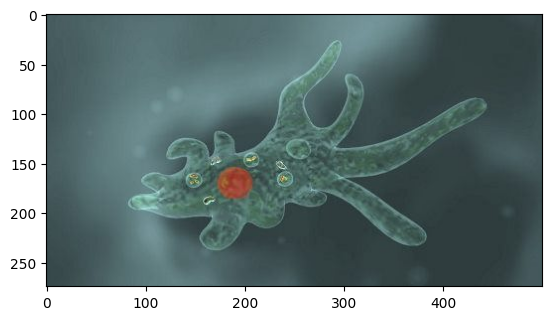

In [11]:
pred_single = trainer.base_model.predict('data/test/Amoeba/Image_23.jpg')
print(pred_single)
plt.imshow(Image.open('data/test/Amoeba/Image_23.jpg'))

In [ ]:
# Obtain the index_to_class dict
idx_to_class = {v: k for k, v in trainer.base_model.class_to_idx.items()}

# Get the real label name
label = idx_to_class[int(pred_single[0]['prediction'])]
print(f'The label is: {label}')

The label is: Amoeba


## Load model with custom weights

In [ ]:

vc = VisionClassifier(model_name=model_name, num_classes = 8, weights_path='test_trainer.pt', device='cuda:0', class_to_idx=class_to_idx)

Now we can use this model to predict a folder with images, a dataset or a single image.